<a href="https://colab.research.google.com/github/rendrasatriar/Density-SILO/blob/Belambus-Tengah/Belambus_Tengah_SAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [ ]:
!pip install --quiet google-cloud-bigquery pandas pyarrow

In [3]:
from google.colab import auth
auth.authenticate_user()

In [27]:
from google.cloud import bigquery
import pandas as pd

PROJECT_ID = "study-density-silo"
DATASET_ID = "study_density"
TABLE_ID = "raw_data_belambus_tengah"

client = bigquery.Client(project=PROJECT_ID)

def fetch_single_block(project: str, dataset: str, table_id: str, max_rows: int = None) -> pd.DataFrame:
    table_full = f"{project}.{dataset}.{table_id}"
    query = f"SELECT * FROM `{table_full}`"
    job = client.query(query)
    if max_rows:
        return job.result(max_results=max_rows).to_dataframe()
    return job.to_dataframe()

In [28]:
# --- Ambil data satu blok ---
df_block = fetch_single_block(PROJECT_ID, DATASET_ID, TABLE_ID)
print(f"Loaded table: {PROJECT_ID}.{DATASET_ID}.{TABLE_ID}")
print("Rows:", len(df_block))
print("Columns:", len(df_block.columns))
print("Shape:", df_block.shape)
print("-" * 60)

# --- Informasi kolom dan tipe data ---
print("\nColumn info:")
print(df_block.dtypes)
print("\nMemory usage (MB):")
print(df_block.memory_usage(deep=True).sum() / 1024**2)

# --- Statistik numerik singkat ---
print("\nDescriptive statistics (numeric columns):")
display(df_block.describe().transpose())

# --- Distribusi kategori penting ---
if 'GEN_LYR' in df_block.columns:
    print("\nUnique GEN_LYR count:", df_block['GEN_LYR'].nunique())
    print("Top GEN_LYR value counts:")
    display(df_block['GEN_LYR'].value_counts().head(20))

if 'Material' in df_block.columns:
    print("\nUnique Material count:", df_block['Material'].nunique())
    print("Top Material value counts:")
    display(df_block['Material'].value_counts().head(20))

# --- Quick QAQC checks ---
print("\nQAQC checks:")
if {'Interval','From','To'}.issubset(df_block.columns):
    n_bad_interval = len(df_block[(df_block['Interval'] <= 0) | (df_block['To'] <= df_block['From'])])
    print("Rows with Interval <= 0 or To <= From:", n_bad_interval)
else:
    print("Columns Interval/From/To not all present for QAQC checks.")

Loaded table: study-density-silo.study_density.raw_data_belambus_tengah
Rows: 867
Columns: 16
Shape: (867, 16)
------------------------------------------------------------

Column info:
HoleId         object
Hill           object
Hill_Group     object
From          float64
To            float64
Interval      float64
CoreRec       float64
WetW          float64
H2O           float64
DryW          float64
Material       object
Layer          object
NEW_LYR        object
GEN_LYR        object
WTF           float64
DTF           float64
dtype: object

Memory usage (MB):
0.3746814727783203

Descriptive statistics (numeric columns):


,count,mean,std,min,25%,50%,75%,max
From,867.0,5.042503,3.302668,0.000000,2.400000,4.900000,7.050000,20.000000
To,867.0,5.730219,3.337493,0.400000,3.000000,5.350000,8.000000,21.000000
Interval,867.0,0.687716,0.301150,0.100000,0.420000,0.690000,1.000000,1.300000
CoreRec,867.0,1.030900,0.169291,0.250000,1.000000,1.000000,1.000000,2.700000
WetW,867.0,3.721141,1.854866,0.325000,2.107500,3.630000,5.230000,9.085000
H2O,867.0,24.804328,15.128021,0.672000,10.919000,24.765000,36.015500,78.159000
DryW,867.0,2.866072,1.621605,0.165000,1.440000,2.600000,4.217500,7.495000
WTF,867.0,1.815195,0.433397,0.202929,1.563115,1.788127,2.014535,5.737705
DTF,867.0,1.372849,0.451556,0.103025,1.063363,1.367692,1.632657,5.256000



Unique GEN_LYR count: 3
Top GEN_LYR value counts:


,count
GEN_LYR,
LIM,459
BRK,254
SAP,154



Unique Material count: 36
Top Material value counts:


,count
Material,
YLIM,129
HGT,121
Rlim,121
Ylim,103
RLIM,48
Rsap,44
Esap,38
Hsap,31
Sap,29



QAQC checks:
Rows with Interval <= 0 or To <= From: 0


# Filter By GEN_LYR

In [47]:
gen_lyr_input = input("Masukkan GEN_LYR yang ingin difilter: ").strip()

# Input beberapa material, pisahkan dengan koma
materials_input = input("Masukkan Material yang ingin difilter (pisahkan dengan koma): ").strip()
materials_list = [m.strip().upper() for m in materials_input.split(",")]

df_filtered = df_block.copy()

# Filter GEN_LYR
if 'GEN_LYR' in df_filtered.columns:
    df_filtered = df_filtered[df_filtered['GEN_LYR'].str.upper() == gen_lyr_input.upper()]

# Filter Material (lebih dari satu)
if 'Material' in df_filtered.columns and len(materials_list) > 0:
    df_filtered = df_filtered[df_filtered['Material'].str.upper().isin(materials_list)]

print(f"\nFiltered rows: {len(df_filtered)}")
display(df_filtered.head(133))

Masukkan GEN_LYR yang ingin difilter: SAP
Masukkan Material yang ingin difilter (pisahkan dengan koma): ESAP,SAP,RSAP,HSAP,YLIM,Esapx,Rsapx,Sapx,Hsapx

Filtered rows: 132


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
254,CS8170162,BATU BERANI,Belambus_Tengah,5.45,5.77,0.32,1.00,1.191,47.775,0.622,ESAP,None,ESAP,SAP,1.273027,0.664838
255,CS4170015,BATU BERANI,Belambus_Tengah,5.00,6.00,1.00,1.50,7.286,38.210,4.502,ESAP,None,ESAP,SAP,1.661398,1.026573
256,CS7211395,Belambus Spasi 50,Belambus_Tengah,4.50,5.00,0.50,1.20,2.500,46.400,1.340,Esap,None,ESAP,SAP,1.425163,0.763887
257,CS7211371,Belambus Spasi 50,Belambus_Tengah,5.35,5.65,0.30,1.00,1.100,54.545,0.500,Esap,None,ESAP,SAP,1.254143,0.570065
258,CS7211397RR,Belambus Spasi 50,Belambus_Tengah,5.00,6.00,1.00,0.80,3.480,51.437,1.690,Esap,None,ESAP,SAP,1.487870,0.722557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,CS8230894RR,Belambus Blok 1 Spasi 100,Belambus_Tengah,5.00,6.00,1.00,0.80,1.815,9.366,1.645,YLIM,LIM,SAP,SAP,0.773463,0.701017
862,CS8230894RR,Belambus Blok 1 Spasi 100,Belambus_Tengah,4.00,4.30,0.30,1.00,0.910,2.198,0.890,YLIM,LIM,SAP,SAP,1.034125,1.011397
863,CS8230894RR,Belambus Blok 1 Spasi 100,Belambus_Tengah,7.00,8.00,1.00,0.45,1.225,6.531,1.145,YLIM,LIM,SAP,SAP,0.928061,0.867453
865,CS8230737,Belambus Blok 1 Spasi 100,Belambus_Tengah,7.74,8.00,0.26,1.00,1.430,48.601,0.735,YLIM,LIM,SAP,SAP,1.875062,0.963756


# Filter By Interval

Descriptive statistics for Interval:
Count: 132
Mean: 0.484848
Standard Error: 0.022917
Median: 0.4
Mode: 1.0
Standard Deviation: 0.263295
Sample Variance: 0.069324
Kurtosis: -0.244433
Skewness: 0.822345
Range: 1.1
Minimum: 0.13
Maximum: 1.23
Sum: 64.0
Confidence Level (95%): ±0.045335

Bin calculation:
Freedman–Diaconis -> bins: 8, bin width: 0.145336
Sturges -> bins: 9, bin width: 0.122222


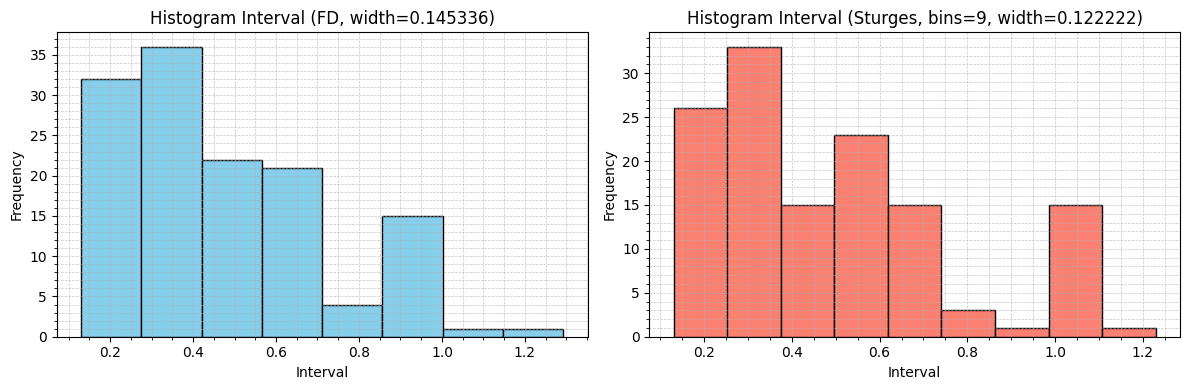


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.130000,0.275336,32
1,0.275336,0.420672,36
2,0.420672,0.566009,22
3,0.566009,0.711345,21
4,0.711345,0.856681,4
5,0.856681,1.002017,15
6,1.002017,1.147353,1
7,1.147353,1.292689,1



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.130000,0.252222,26
1,0.252222,0.374444,33
2,0.374444,0.496667,15
3,0.496667,0.618889,23
4,0.618889,0.741111,15
5,0.741111,0.863333,3
6,0.863333,0.985556,1
7,0.985556,1.107778,15
8,1.107778,1.230000,1


In [48]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return int(np.sqrt(n)), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series):
    data = series.dropna().values
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    se = stats.sem(data)
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0] if n > 0 else None
    var = np.var(data, ddof=1)
    kurt = stats.kurtosis(data)
    skew = stats.skew(data)
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else None

    print("Descriptive statistics for Interval:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}")
    print(f"Sample Variance: {var:.6f}")
    print(f"Kurtosis: {kurt:.6f}")
    print(f"Skewness: {skew:.6f}")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): \u00b1{conf95:.6f}")

def plot_interval_histograms(df_filtered):
    if 'Interval' not in df_filtered.columns:
        print("Kolom 'Interval' tidak ada di dataframe.")
        return

    data = df_filtered['Interval'].dropna()

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data)

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins: {bins_fd}, bin width: {width_fd_str}")
    print(f"Sturges -> bins: {bins_st}, bin width: {width_st_str}")

    # --- plot histogram dengan minor ticks ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram Interval (FD, width={width_fd_str})")
    axes[0].set_xlabel("Interval")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(AutoMinorLocator())
    axes[0].yaxis.set_minor_locator(AutoMinorLocator())
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram Interval (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("Interval")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(AutoMinorLocator())
    axes[1].yaxis.set_minor_locator(AutoMinorLocator())
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
interval_data = plot_interval_histograms(df_filtered) # Corrected function call

In [49]:
# Pastikan df_filtered sudah ada
# Contoh: df_filtered = filter_data(df_block, "LIM", "RLIM")

# Minta input dari user
lower_bound = float(input("Masukkan batas bawah (is greater than or equal to): "))
upper_bound = float(input("Masukkan batas atas (is less than or equal to): "))

# Filter data sesuai input
df_interval = df_filtered[(df_filtered['Interval'] >= lower_bound) &
                       (df_filtered['Interval'] <= upper_bound)]

print(f"\nFiltered rows: {len(df_interval)}")
display(df_interval.head(50))

Masukkan batas bawah (is greater than or equal to): 0.130000
Masukkan batas atas (is less than or equal to): 0.711345

Filtered rows: 111


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
254,CS8170162,BATU BERANI,Belambus_Tengah,5.45,5.77,0.32,1.00,1.191,47.775,0.622,ESAP,None,ESAP,SAP,1.273027,0.664838
256,CS7211395,Belambus Spasi 50,Belambus_Tengah,4.50,5.00,0.50,1.20,2.500,46.400,1.340,Esap,None,ESAP,SAP,1.425163,0.763887
257,CS7211371,Belambus Spasi 50,Belambus_Tengah,5.35,5.65,0.30,1.00,1.100,54.545,0.500,Esap,None,ESAP,SAP,1.254143,0.570065
259,CS7211442,Belambus Spasi 50,Belambus_Tengah,6.20,6.54,0.34,1.38,1.660,42.771,0.950,Esap,None,ESAP,SAP,1.210113,0.692534
260,CS7211442,Belambus Spasi 50,Belambus_Tengah,7.00,7.56,0.56,1.30,2.910,50.515,1.440,Esap,None,ESAP,SAP,1.367216,0.676561
261,CS7211443,Belambus Spasi 50,Belambus_Tengah,7.66,8.00,0.34,0.90,0.825,50.303,0.410,Esap,None,ESAP,SAP,0.922164,0.458288
262,CS7211448,Belambus Spasi 50,Belambus_Tengah,3.70,4.25,0.55,1.00,2.390,45.188,1.310,Esap,None,ESAP,SAP,1.486315,0.814675
263,CS7211469,Belambus Spasi 50,Belambus_Tengah,7.00,7.60,0.60,1.25,3.370,46.439,1.805,Esap,None,ESAP,SAP,1.536895,0.823174
265,CS7211373,Belambus Spasi 50,Belambus_Tengah,4.50,5.00,0.50,0.80,1.660,46.988,0.880,Esap,None,ESAP,SAP,1.419462,0.752486
266,CS7211442,Belambus Spasi 50,Belambus_Tengah,6.54,7.00,0.46,1.41,2.560,49.609,1.290,Esap,None,ESAP,SAP,1.350015,0.680281


# Filter By Recovery


Descriptive statistics for CoreRec:
Count: 111
Mean: 1.077207
Standard Error: 0.025373
Median: 1.0
Mode: 1.0
Standard Deviation: 0.267317
Sample Variance: 0.071458
Kurtosis: 19.138191
Skewness: 3.893049
Range: 2.1
Minimum: 0.6
Maximum: 2.7
Sum: 119.57000000000001
Confidence Level (95%): ±0.050283

Bin calculation:
Freedman–Diaconis -> bins=10, width=N/A
Sturges -> bins=8, width=0.262500


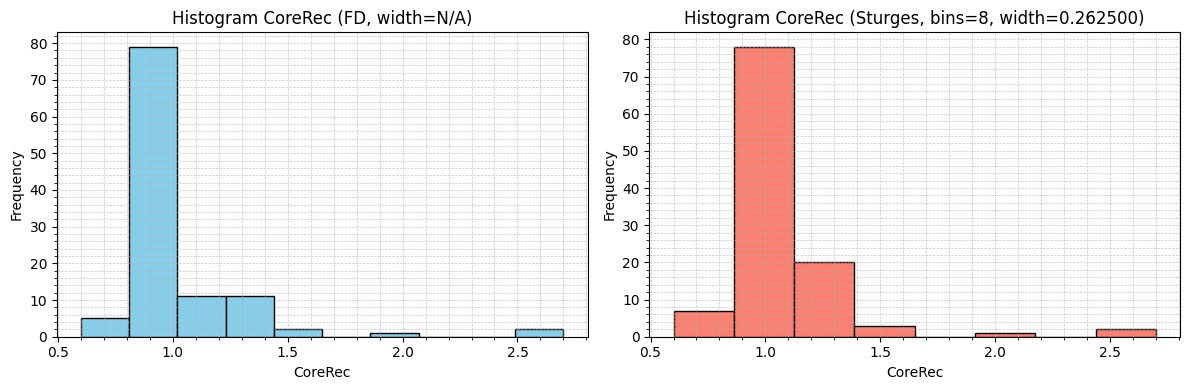


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.60,0.81,5
1,0.81,1.02,79
2,1.02,1.23,11
3,1.23,1.44,11
4,1.44,1.65,2
5,1.65,1.86,0
6,1.86,2.07,1
7,2.07,2.28,0
8,2.28,2.49,0
9,2.49,2.70,2



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.6000,0.8625,7
1,0.8625,1.1250,78
2,1.1250,1.3875,20
3,1.3875,1.6500,3
4,1.6500,1.9125,0
5,1.9125,2.1750,1
6,2.1750,2.4375,0
7,2.4375,2.7000,2


In [50]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="CoreRec"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_coreRec(df_interval):
    if 'CoreRec' not in df_interval.columns:
        print("Kolom 'CoreRec' tidak ada di dataframe.")
        return

    data = df_interval['CoreRec'].dropna()
    if data.empty:
        print("Tidak ada data 'CoreRec' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="CoreRec")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram CoreRec (FD, width={width_fd_str})")
    axes[0].set_xlabel("CoreRec")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(AutoMinorLocator())
    axes[0].yaxis.set_minor_locator(AutoMinorLocator())
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram CoreRec (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("CoreRec")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(AutoMinorLocator())
    axes[1].yaxis.set_minor_locator(AutoMinorLocator())
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
coreRec_data = analyze_coreRec(df_interval)

In [51]:
lower_bound = float(input("Masukkan batas bawah (is greater than or equal to): "))
upper_bound = float(input("Masukkan batas atas (is less than or equal to): "))


df_recovery = df_interval[(df_interval['CoreRec'] >= lower_bound) &
                       (df_interval['CoreRec'] <= upper_bound)]

print(f"\nFiltered rows: {len(df_recovery)}")
display(df_recovery.head(47))

Masukkan batas bawah (is greater than or equal to): 0.81
Masukkan batas atas (is less than or equal to): 1.02

Filtered rows: 79


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
254,CS8170162,BATU BERANI,Belambus_Tengah,5.45,5.77,0.32,1.00,1.191,47.775,0.622,ESAP,None,ESAP,SAP,1.273027,0.664838
257,CS7211371,Belambus Spasi 50,Belambus_Tengah,5.35,5.65,0.30,1.00,1.100,54.545,0.500,Esap,None,ESAP,SAP,1.254143,0.570065
261,CS7211443,Belambus Spasi 50,Belambus_Tengah,7.66,8.00,0.34,0.90,0.825,50.303,0.410,Esap,None,ESAP,SAP,0.922164,0.458288
262,CS7211448,Belambus Spasi 50,Belambus_Tengah,3.70,4.25,0.55,1.00,2.390,45.188,1.310,Esap,None,ESAP,SAP,1.486315,0.814675
268,CS7211417,Belambus Spasi 50,Belambus_Tengah,5.35,5.65,0.30,1.00,1.330,36.090,0.850,Esap,None,ESAP,SAP,1.516373,0.969111
273,CS7211395,Belambus Spasi 50,Belambus_Tengah,5.00,5.20,0.20,1.00,0.940,46.809,0.500,Hsap,None,ESAP,SAP,1.607583,0.855098
274,CS7211423,Belambus Spasi 50,Belambus_Tengah,4.14,4.29,0.15,1.00,0.590,32.203,0.400,Hsap,None,ESAP,SAP,1.345354,0.912104
275,CS8170156R,BATU BERANI,Belambus_Tengah,4.75,5.00,0.25,1.00,0.828,21.014,0.654,RSAP,None,ESAP,SAP,1.132833,0.894774
276,CS7211371,Belambus Spasi 50,Belambus_Tengah,6.00,6.15,0.15,1.00,0.690,36.232,0.440,Rsap,None,ESAP,SAP,1.573380,1.003315
280,CS7211371,Belambus Spasi 50,Belambus_Tengah,5.65,6.00,0.35,1.00,1.520,34.868,0.990,Rsap,None,ESAP,SAP,1.485427,0.967482


# Filter By Wet Weight

Tidak ada data dengan Interval=1.0 dan CoreRec=1.0.
Menggunakan seluruh data sebagai acuan residual.

Residual IQR acuan:
Q1: -0.190, Q3: 0.174, IQR: 0.364
Lower margin: -0.735, Upper margin: 0.719


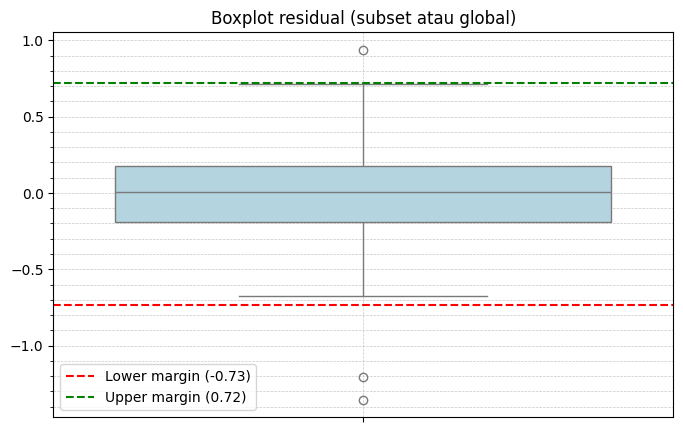

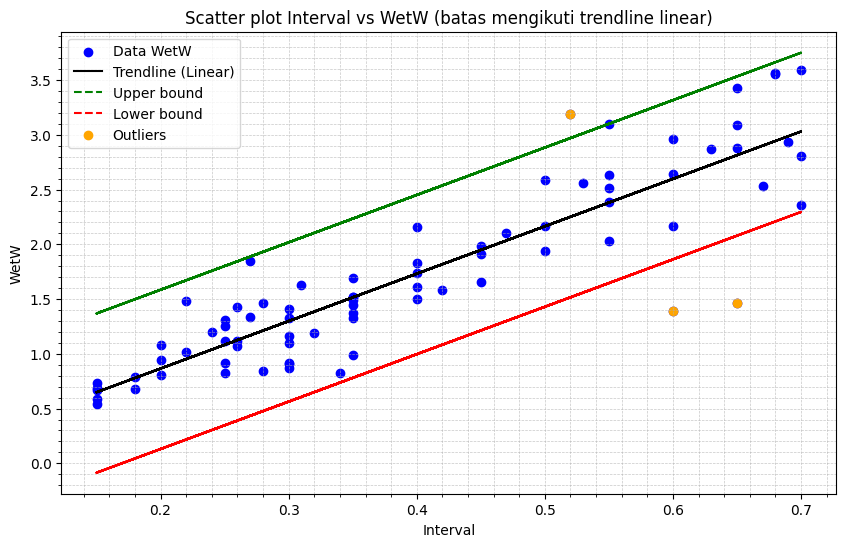


Outlier WetW berdasarkan trendline linear + IQR residual acuan:
        HoleId                       Hill       Hill_Group  From    To  \
771  CS7211423          Belambus Spasi 50  Belambus_Tengah  4.48  5.00   
776  CS7211394          Belambus Spasi 50  Belambus_Tengah  5.35  6.00   
824  CS8230862  Belambus Blok 1 Spasi 100  Belambus_Tengah  7.85  8.45   

     Interval  CoreRec  WetW     H2O  DryW Material Layer NEW_LYR GEN_LYR  \
771      0.52     1.00  3.19  39.812  1.92     Hsap  None    RSAP     SAP   
776      0.65     1.00  1.46   3.425  1.41     Rsap  None    RSAP     SAP   
824      0.60     0.91  1.39  39.568  0.84     RSAP   SAP     SAP     SAP   

          WTF       DTF  
771  2.098278  1.262913  
776  0.768272  0.741962  
824  0.867911  0.524493  


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

def detect_outliers_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00):
    # --- Filter subset sesuai kriteria ---
    subset = df_recovery[(df_recovery['Interval'] == interval_value) &
                         (df_recovery['CoreRec'] == coreRec_value)]

    # --- Fit trendline linear (Interval vs WetW) ---
    X = df_recovery['Interval'].values.reshape(-1,1)
    y = df_recovery['WetW'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # --- Tentukan subset untuk residual ---
    if subset.empty:
        print(f"Tidak ada data dengan Interval={interval_value} dan CoreRec={coreRec_value}.")
        print("Menggunakan seluruh data sebagai acuan residual.")
        subset_X = X
        subset_y = y
    else:
        subset_X = subset['Interval'].values.reshape(-1,1)
        subset_y = subset['WetW'].values

    subset_pred = model.predict(subset_X)
    residuals = subset_y - subset_pred

    # --- Hitung IQR residual subset/global ---
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1
    lower_margin = q1 - 1.5 * iqr
    upper_margin = q3 + 1.5 * iqr

    print(f"\nResidual IQR acuan:")
    print(f"Q1: {q1:.3f}, Q3: {q3:.3f}, IQR: {iqr:.3f}")
    print(f"Lower margin: {lower_margin:.3f}, Upper margin: {upper_margin:.3f}")

    # --- Boxplot residual subset/global ---
    plt.figure(figsize=(8,5))
    sns.boxplot(y=residuals, color='lightblue')
    plt.axhline(lower_margin, color='red', linestyle='--', label=f'Lower margin ({lower_margin:.2f})')
    plt.axhline(upper_margin, color='green', linestyle='--', label=f'Upper margin ({upper_margin:.2f})')
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Boxplot residual (subset atau global)")
    plt.legend()
    plt.show()

    # --- Scatter plot seluruh data + trendline + batas mengikuti trendline ---
    plt.figure(figsize=(10,6))
    plt.scatter(df_recovery['Interval'], df_recovery['WetW'], color='blue', label='Data WetW')
    plt.plot(df_recovery['Interval'], y_pred, color='black', label='Trendline (Linear)')

    # Batas atas/bawah mengikuti trendline
    plt.plot(df_recovery['Interval'], y_pred + upper_margin, color='green', linestyle='--', label='Upper bound')
    plt.plot(df_recovery['Interval'], y_pred + lower_margin, color='red', linestyle='--', label='Lower bound')

    # Outlier = data di luar batas trendline ± margin
    outliers = df_recovery[(df_recovery['WetW'] > y_pred + upper_margin) |
                           (df_recovery['WetW'] < y_pred + lower_margin)]
    if not outliers.empty:
        plt.scatter(outliers['Interval'], outliers['WetW'], color='orange', label='Outliers')

    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Scatter plot Interval vs WetW (batas mengikuti trendline linear)")
    plt.xlabel("Interval")
    plt.ylabel("WetW")
    plt.legend()
    plt.show()

    return {
        "outliers": outliers,
        "margins": {"lower": lower_margin, "upper": upper_margin},
        "trendline_coef": {"slope": model.coef_[0], "intercept": model.intercept_}
    }

# --- Contoh pemanggilan ---
result = detect_outliers_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00)
if result:
    print("\nOutlier WetW berdasarkan trendline linear + IQR residual acuan:")
    print(result["outliers"].head())

## Normalisasi Weight terhadap recovery

In [53]:
import numpy as np
from IPython.display import display

def normalize_wetw(df_recovery):
    if 'WetW' not in df_recovery.columns or 'CoreRec' not in df_recovery.columns:
        print("Kolom 'WetW' atau 'CoreRec' tidak ada di dataframe.")
        return df_recovery

    # Buat kolom baru Normalized_WetW
    df_recovery['Normalized_WetW'] = np.where(
        df_recovery['CoreRec'] > 1.0,
        df_recovery['WetW'] / 1,          # jika CoreRec > 1.0
        df_recovery['WetW'] / df_recovery['CoreRec']  # jika CoreRec <= 1.0
    )

    print("\nNormalisasi WetW terhadap Recovery selesai.")
    # tampilkan seluruh dataframe dengan kolom tambahan
    display(df_recovery)

    return df_recovery

# --- Contoh pemanggilan ---
df_recovery = normalize_wetw(df_recovery)


Normalisasi WetW terhadap Recovery selesai.


/tmp/ipython-input-7809237.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Normalized_WetW'] = np.where(


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW
254,CS8170162,BATU BERANI,Belambus_Tengah,5.45,5.77,0.32,1.0,1.191,47.775,0.622,ESAP,None,ESAP,SAP,1.273027,0.664838,1.191000
257,CS7211371,Belambus Spasi 50,Belambus_Tengah,5.35,5.65,0.30,1.0,1.100,54.545,0.500,Esap,None,ESAP,SAP,1.254143,0.570065,1.100000
261,CS7211443,Belambus Spasi 50,Belambus_Tengah,7.66,8.00,0.34,0.9,0.825,50.303,0.410,Esap,None,ESAP,SAP,0.922164,0.458288,0.916667
262,CS7211448,Belambus Spasi 50,Belambus_Tengah,3.70,4.25,0.55,1.0,2.390,45.188,1.310,Esap,None,ESAP,SAP,1.486315,0.814675,2.390000
268,CS7211417,Belambus Spasi 50,Belambus_Tengah,5.35,5.65,0.30,1.0,1.330,36.090,0.850,Esap,None,ESAP,SAP,1.516373,0.969111,1.330000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,CS8230894RR,Belambus Blok 1 Spasi 100,Belambus_Tengah,4.30,5.00,0.70,1.0,2.355,9.130,2.140,YLIM,LIM,SAP,SAP,1.146953,1.042242,2.355000
858,CS8230743,Belambus Blok 1 Spasi 100,Belambus_Tengah,4.76,5.00,0.24,1.0,1.200,44.583,0.665,YLIM,LIM,SAP,SAP,1.704602,0.944633,1.200000
859,CS8230737,Belambus Blok 1 Spasi 100,Belambus_Tengah,8.00,8.68,0.68,1.0,3.555,49.226,1.805,YLIM,LIM,SAP,SAP,1.782312,0.904943,3.555000
862,CS8230894RR,Belambus Blok 1 Spasi 100,Belambus_Tengah,4.00,4.30,0.30,1.0,0.910,2.198,0.890,YLIM,LIM,SAP,SAP,1.034125,1.011397,0.910000


Tidak ada data dengan Interval=1.0 dan CoreRec=1.0.
Menggunakan seluruh data sebagai acuan residual.

Residual IQR acuan:
Q1: -0.177, Q3: 0.210, IQR: 0.387
Lower margin: -0.758, Upper margin: 0.791


/tmp/ipython-input-1577443899.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Trendline_Pred'] = model.predict(df_recovery['Interval'].values.reshape(-1,1))
/tmp/ipython-input-1577443899.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Outlier_Status'] = [


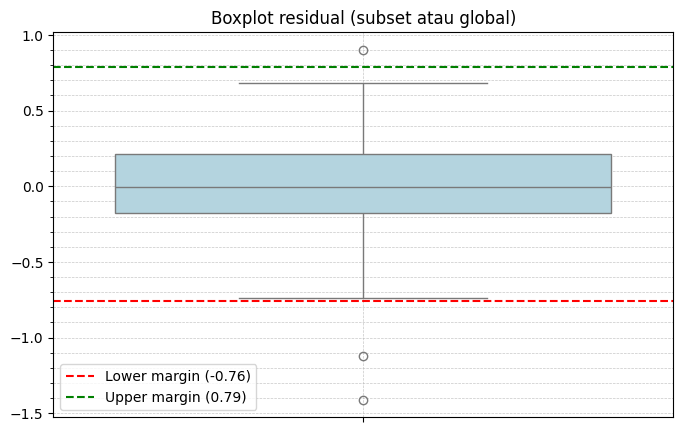

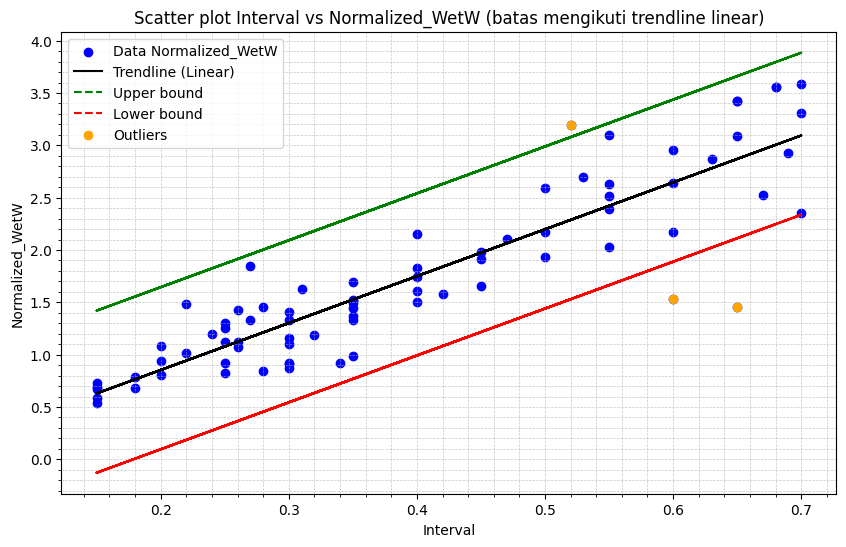

,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred,Outlier_Status
254,CS8170162,BATU BERANI,Belambus_Tengah,5.45,5.77,0.32,1.0,1.191,47.775,0.622,ESAP,None,ESAP,SAP,1.273027,0.664838,1.191000,1.391471,Normal
257,CS7211371,Belambus Spasi 50,Belambus_Tengah,5.35,5.65,0.30,1.0,1.100,54.545,0.500,Esap,None,ESAP,SAP,1.254143,0.570065,1.100000,1.301880,Normal
261,CS7211443,Belambus Spasi 50,Belambus_Tengah,7.66,8.00,0.34,0.9,0.825,50.303,0.410,Esap,None,ESAP,SAP,0.922164,0.458288,0.916667,1.481061,Normal
262,CS7211448,Belambus Spasi 50,Belambus_Tengah,3.70,4.25,0.55,1.0,2.390,45.188,1.310,Esap,None,ESAP,SAP,1.486315,0.814675,2.390000,2.421765,Normal
268,CS7211417,Belambus Spasi 50,Belambus_Tengah,5.35,5.65,0.30,1.0,1.330,36.090,0.850,Esap,None,ESAP,SAP,1.516373,0.969111,1.330000,1.301880,Normal
273,CS7211395,Belambus Spasi 50,Belambus_Tengah,5.00,5.20,0.20,1.0,0.940,46.809,0.500,Hsap,None,ESAP,SAP,1.607583,0.855098,0.940000,0.853926,Normal
274,CS7211423,Belambus Spasi 50,Belambus_Tengah,4.14,4.29,0.15,1.0,0.590,32.203,0.400,Hsap,None,ESAP,SAP,1.345354,0.912104,0.590000,0.629949,Normal
275,CS8170156R,BATU BERANI,Belambus_Tengah,4.75,5.00,0.25,1.0,0.828,21.014,0.654,RSAP,None,ESAP,SAP,1.132833,0.894774,0.828000,1.077903,Normal
276,CS7211371,Belambus Spasi 50,Belambus_Tengah,6.00,6.15,0.15,1.0,0.690,36.232,0.440,Rsap,None,ESAP,SAP,1.573380,1.003315,0.690000,0.629949,Normal
280,CS7211371,Belambus Spasi 50,Belambus_Tengah,5.65,6.00,0.35,1.0,1.520,34.868,0.990,Rsap,None,ESAP,SAP,1.485427,0.967482,1.520000,1.525857,Normal


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

def detect_outliers_normalized_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00):
    # --- Filter subset sesuai kriteria ---
    subset = df_recovery[(df_recovery['Interval'] == interval_value) &
                         (df_recovery['CoreRec'] == coreRec_value)]

    # --- Fit trendline linear (Interval vs Normalized_WetW) ---
    X = df_recovery['Interval'].values.reshape(-1,1)
    y = df_recovery['Normalized_WetW'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # --- Tentukan subset untuk residual ---
    if subset.empty:
        print(f"Tidak ada data dengan Interval={interval_value} dan CoreRec={coreRec_value}.")
        print("Menggunakan seluruh data sebagai acuan residual.")
        subset_X = X
        subset_y = y
    else:
        subset_X = subset['Interval'].values.reshape(-1,1)
        subset_y = subset['Normalized_WetW'].values

    subset_pred = model.predict(subset_X)
    residuals = subset_y - subset_pred

    # --- Hitung IQR residual subset/global ---
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1
    lower_margin = q1 - 1.5 * iqr
    upper_margin = q3 + 1.5 * iqr

    print(f"\nResidual IQR acuan:")
    print(f"Q1: {q1:.3f}, Q3: {q3:.3f}, IQR: {iqr:.3f}")
    print(f"Lower margin: {lower_margin:.3f}, Upper margin: {upper_margin:.3f}")

    # --- Tambahkan kolom status outlier ---
    def classify_outlier(val, pred):
        if val < pred + lower_margin:
            return "Outlier bawah"
        elif val > pred + upper_margin:
            return "Outlier atas"
        else:
            return "Normal"

    df_recovery['Trendline_Pred'] = model.predict(df_recovery['Interval'].values.reshape(-1,1))
    df_recovery['Outlier_Status'] = [
        classify_outlier(val, pred)
        for val, pred in zip(df_recovery['Normalized_WetW'], df_recovery['Trendline_Pred'])
    ]

    # --- Boxplot residual subset/global ---
    plt.figure(figsize=(8,5))
    sns.boxplot(y=residuals, color='lightblue')
    plt.axhline(lower_margin, color='red', linestyle='--', label=f'Lower margin ({lower_margin:.2f})')
    plt.axhline(upper_margin, color='green', linestyle='--', label=f'Upper margin ({upper_margin:.2f})')
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Boxplot residual (subset atau global)")
    plt.legend()
    plt.show()

    # --- Scatter plot seluruh data + trendline + batas mengikuti trendline ---
    plt.figure(figsize=(10,6))
    plt.scatter(df_recovery['Interval'], df_recovery['Normalized_WetW'], color='blue', label='Data Normalized_WetW')
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'], color='black', label='Trendline (Linear)')

    # Batas atas/bawah mengikuti trendline
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'] + upper_margin,
             color='green', linestyle='--', label='Upper bound')
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'] + lower_margin,
             color='red', linestyle='--', label='Lower bound')

    # Outlier ditandai oranye
    outliers = df_recovery[df_recovery['Outlier_Status'] != "Normal"]
    if not outliers.empty:
        plt.scatter(outliers['Interval'], outliers['Normalized_WetW'], color='orange', label='Outliers')

    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Scatter plot Interval vs Normalized_WetW (batas mengikuti trendline linear)")
    plt.xlabel("Interval")
    plt.ylabel("Normalized_WetW")
    plt.legend()
    plt.show()

    return df_recovery

# --- Contoh pemanggilan ---
df_recovery = detect_outliers_normalized_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00)
display(df_recovery.head(15))


Bin calculation:
Freedman–Diaconis -> bins=6, width=0.546513
Sturges -> bins=8, width=0.381250


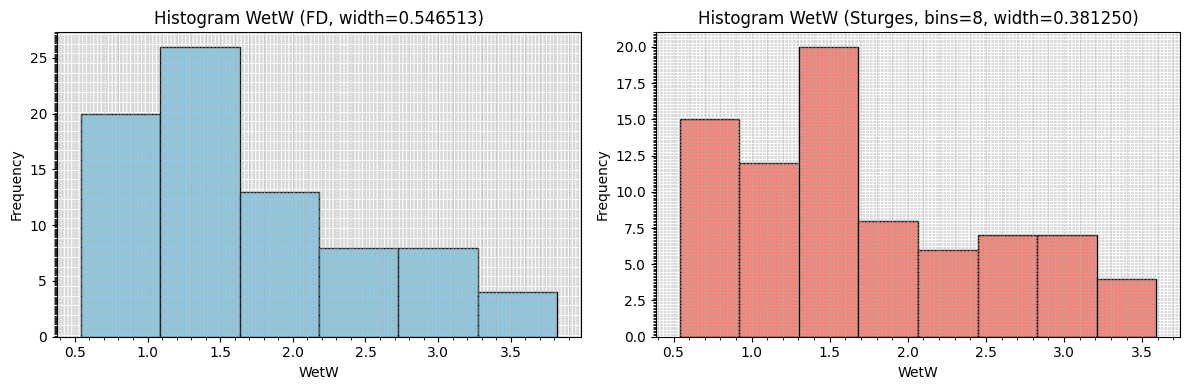


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.540000,1.086513,20
1,1.086513,1.633026,26
2,1.633026,2.179539,13
3,2.179539,2.726052,8
4,2.726052,3.272565,8
5,3.272565,3.819078,4



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.54000,0.92125,15
1,0.92125,1.30250,12
2,1.30250,1.68375,20
3,1.68375,2.06500,8
4,2.06500,2.44625,6
5,2.44625,2.82750,7
6,2.82750,3.20875,7
7,3.20875,3.59000,4


In [55]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def analyze_wetw(df_recovery):
    if 'WetW' not in df_recovery.columns:
        print("Kolom 'WetW' tidak ada di dataframe.")
        return

    data = df_recovery['WetW'].dropna()
    if data.empty:
        print("Tidak ada data 'WetW' yang valid setelah drop NaN.")
        return

    # --- hitung jumlah bins ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram WetW (FD, width={width_fd_str})")
    axes[0].set_xlabel("WetW")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram WetW (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("WetW")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
wetw_data = analyze_wetw(df_recovery)

In [56]:
import numpy as np
from IPython.display import display

def filter_wetw_normal(df_recovery, lower_bound, upper_bound):
    """
    Filter data WetW berdasarkan batas bawah/atas,
    sekaligus memastikan hanya baris dengan Outlier_Status = 'Normal' yang lolos.
    Setelah selesai, kolom Outlier_Status dihapus.
    """
    # --- Filter berdasarkan WetW ---
    df_wetw = df_recovery[(df_recovery['WetW'] >= lower_bound) &
                          (df_recovery['WetW'] <= upper_bound)].copy()

    # --- Pastikan hanya baris Normal yang lolos ---
    if 'Outlier_Status' in df_wetw.columns:
        df_wetw = df_wetw[df_wetw['Outlier_Status'] == "Normal"].copy()
        # Drop kolom Outlier_Status setelah selesai
        df_wetw = df_wetw.drop(columns=['Outlier_Status'])
    else:
        print("Kolom Outlier_Status tidak ditemukan, hanya filter WetW yang diterapkan.")

    print(f"\nFiltered rows (Normal only): {len(df_wetw)}")
    display(df_wetw.head(10))

    return df_wetw

# --- Contoh pemanggilan ---
lower_bound = float(input("Masukkan batas bawah (>=): "))
upper_bound = float(input("Masukkan batas atas (<=): "))

df_wetw = filter_wetw_normal(df_recovery, lower_bound, upper_bound)

Masukkan batas bawah (>=): 0.540000
Masukkan batas atas (<=): 1.633026

Filtered rows (Normal only): 44


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
254,CS8170162,BATU BERANI,Belambus_Tengah,5.45,5.77,0.32,1.0,1.191,47.775,0.622,ESAP,None,ESAP,SAP,1.273027,0.664838,1.191000,1.391471
257,CS7211371,Belambus Spasi 50,Belambus_Tengah,5.35,5.65,0.30,1.0,1.100,54.545,0.500,Esap,None,ESAP,SAP,1.254143,0.570065,1.100000,1.301880
261,CS7211443,Belambus Spasi 50,Belambus_Tengah,7.66,8.00,0.34,0.9,0.825,50.303,0.410,Esap,None,ESAP,SAP,0.922164,0.458288,0.916667,1.481061
268,CS7211417,Belambus Spasi 50,Belambus_Tengah,5.35,5.65,0.30,1.0,1.330,36.090,0.850,Esap,None,ESAP,SAP,1.516373,0.969111,1.330000,1.301880
273,CS7211395,Belambus Spasi 50,Belambus_Tengah,5.00,5.20,0.20,1.0,0.940,46.809,0.500,Hsap,None,ESAP,SAP,1.607583,0.855098,0.940000,0.853926
274,CS7211423,Belambus Spasi 50,Belambus_Tengah,4.14,4.29,0.15,1.0,0.590,32.203,0.400,Hsap,None,ESAP,SAP,1.345354,0.912104,0.590000,0.629949
275,CS8170156R,BATU BERANI,Belambus_Tengah,4.75,5.00,0.25,1.0,0.828,21.014,0.654,RSAP,None,ESAP,SAP,1.132833,0.894774,0.828000,1.077903
276,CS7211371,Belambus Spasi 50,Belambus_Tengah,6.00,6.15,0.15,1.0,0.690,36.232,0.440,Rsap,None,ESAP,SAP,1.573380,1.003315,0.690000,0.629949
280,CS7211371,Belambus Spasi 50,Belambus_Tengah,5.65,6.00,0.35,1.0,1.520,34.868,0.990,Rsap,None,ESAP,SAP,1.485427,0.967482,1.520000,1.525857
282,CS7211468,Belambus Spasi 50,Belambus_Tengah,8.50,8.65,0.15,1.0,0.730,56.164,0.320,Rsap,None,ESAP,SAP,1.664590,0.729683,0.730000,0.629949


#Filter By MC


Descriptive statistics for H2O:
Count: 44
Mean: 39.522477
Standard Error: 1.787224
Median: 40.735
Mode: 2.198
Standard Deviation: 11.855101
Sample Variance: 140.543418
Kurtosis: 0.733951
Skewness: -0.784595
Range: 55.566
Minimum: 2.198
Maximum: 57.764
Sum: 1738.9890000000005
Confidence Level (95%): ±3.604280

Bin calculation:
Freedman–Diaconis -> bins=6, width=9.389300
Sturges -> bins=7, width=7.938000


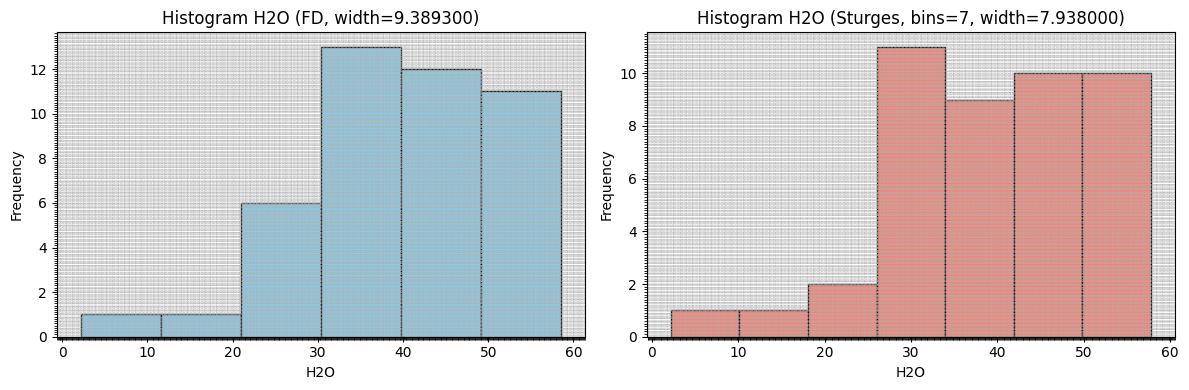


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,2.198000,11.587300,1
1,11.587300,20.976600,1
2,20.976600,30.365900,6
3,30.365900,39.755200,13
4,39.755200,49.144501,12
5,49.144501,58.533801,11



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,2.198,10.136,1
1,10.136,18.074,1
2,18.074,26.012,2
3,26.012,33.950,11
4,33.950,41.888,9
5,41.888,49.826,10
6,49.826,57.764,10


In [57]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="H2O"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_h2o(df_wetw):
    if 'H2O' not in df_wetw.columns:
        print("Kolom 'H2O' tidak ada di dataframe.")
        return

    data = df_wetw['H2O'].dropna()
    if data.empty:
        print("Tidak ada data 'H2O' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="H2O")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks interval 0.1 ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram H2O (FD, width={width_fd_str})")
    axes[0].set_xlabel("H2O")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram H2O (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("H2O")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
h2o_data = analyze_h2o(df_wetw)

In [58]:

import numpy as np
from IPython.display import display

# Input batas bawah dan atas untuk H2O
lower_bound = float(input("is greater than or equal to: "))
upper_bound = float(input("is less than or equal to: "))

# Filter df_wetw berdasarkan H2O
df_h2o = df_wetw[(df_wetw['H2O'] >= lower_bound) &
                 (df_wetw['H2O'] <= upper_bound)].copy()

print(f"\nFiltered rows (H2O): {len(df_h2o)}")
display(df_h2o.head(10))

is greater than or equal to: 26.012
is less than or equal to: 57.764

Filtered rows (H2O): 40


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
254,CS8170162,BATU BERANI,Belambus_Tengah,5.45,5.77,0.32,1.0,1.191,47.775,0.622,ESAP,None,ESAP,SAP,1.273027,0.664838,1.191000,1.391471
257,CS7211371,Belambus Spasi 50,Belambus_Tengah,5.35,5.65,0.30,1.0,1.100,54.545,0.500,Esap,None,ESAP,SAP,1.254143,0.570065,1.100000,1.301880
261,CS7211443,Belambus Spasi 50,Belambus_Tengah,7.66,8.00,0.34,0.9,0.825,50.303,0.410,Esap,None,ESAP,SAP,0.922164,0.458288,0.916667,1.481061
268,CS7211417,Belambus Spasi 50,Belambus_Tengah,5.35,5.65,0.30,1.0,1.330,36.090,0.850,Esap,None,ESAP,SAP,1.516373,0.969111,1.330000,1.301880
273,CS7211395,Belambus Spasi 50,Belambus_Tengah,5.00,5.20,0.20,1.0,0.940,46.809,0.500,Hsap,None,ESAP,SAP,1.607583,0.855098,0.940000,0.853926
274,CS7211423,Belambus Spasi 50,Belambus_Tengah,4.14,4.29,0.15,1.0,0.590,32.203,0.400,Hsap,None,ESAP,SAP,1.345354,0.912104,0.590000,0.629949
276,CS7211371,Belambus Spasi 50,Belambus_Tengah,6.00,6.15,0.15,1.0,0.690,36.232,0.440,Rsap,None,ESAP,SAP,1.573380,1.003315,0.690000,0.629949
280,CS7211371,Belambus Spasi 50,Belambus_Tengah,5.65,6.00,0.35,1.0,1.520,34.868,0.990,Rsap,None,ESAP,SAP,1.485427,0.967482,1.520000,1.525857
282,CS7211468,Belambus Spasi 50,Belambus_Tengah,8.50,8.65,0.15,1.0,0.730,56.164,0.320,Rsap,None,ESAP,SAP,1.664590,0.729683,0.730000,0.629949
285,CS4170015,BATU BERANI,Belambus_Tengah,6.00,6.30,0.30,1.0,1.409,45.635,0.766,SAP,None,ESAP,SAP,1.606443,0.873340,1.409000,1.301880


# Filter By DTF


Descriptive statistics for DTF:
Count: 40
Mean: 0.849418
Standard Error: 0.031715
Median: 0.874907364
Mode: 0.579564601
Standard Deviation: 0.200586
Sample Variance: 0.040235
Kurtosis: -0.344257
Skewness: 0.140259
Range: 0.8303913319999999
Minimum: 0.458287604
Maximum: 1.288678936
Sum: 33.976739406
Confidence Level (95%): ±0.064150

Bin calculation:
Freedman–Diaconis -> bins=6, width=0.139873
Sturges -> bins=7, width=0.118627


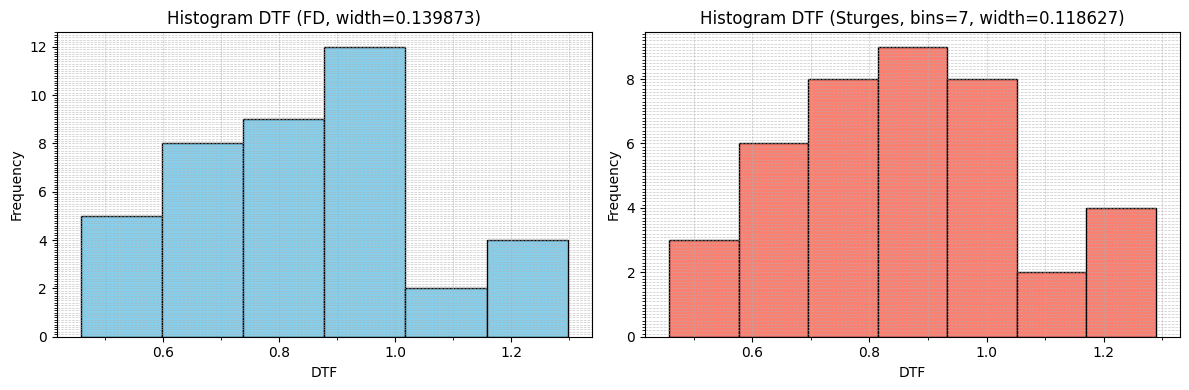


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.458288,0.598160,5
1,0.598160,0.738033,8
2,0.738033,0.877906,9
3,0.877906,1.017779,12
4,1.017779,1.157652,2
5,1.157652,1.297525,4



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.458288,0.576915,3
1,0.576915,0.695542,6
2,0.695542,0.814170,8
3,0.814170,0.932797,9
4,0.932797,1.051424,8
5,1.051424,1.170052,2
6,1.170052,1.288679,4


In [59]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="DTF"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_dtf(df_h2o):
    if 'DTF' not in df_h2o.columns:
        print("Kolom 'DTF' tidak ada di dataframe.")
        return

    data = df_h2o['DTF'].dropna()
    if data.empty:
        print("Tidak ada data 'DTF' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="DTF")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks interval 0.1 ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram DTF (FD, width={width_fd_str})")
    axes[0].set_xlabel("DTF")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram DTF (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("DTF")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
dtf_data = analyze_dtf(df_h2o)

In [63]:
import numpy as np
from IPython.display import display

# Input batas bawah dan atas untuk H2O
lower_bound = float(input("is greater than or equal to: "))
upper_bound = float(input("is less than or equal to: "))

# Filter df_h2o berdasarkan DTF
df_dtf = df_h2o[(df_h2o['DTF'] >= lower_bound) &
                (df_h2o['DTF'] <= upper_bound)].copy()

print(f"\nFiltered rows (DTF): {len(df_dtf)}")
display(df_dtf.head(89))

is greater than or equal to: 0.695542
is less than or equal to: 1.051424

Filtered rows (DTF): 25


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
268,CS7211417,Belambus Spasi 50,Belambus_Tengah,5.35,5.65,0.30,1.0,1.330,36.090,0.850,Esap,None,ESAP,SAP,1.516373,0.969111,1.330,1.301880
273,CS7211395,Belambus Spasi 50,Belambus_Tengah,5.00,5.20,0.20,1.0,0.940,46.809,0.500,Hsap,None,ESAP,SAP,1.607583,0.855098,0.940,0.853926
274,CS7211423,Belambus Spasi 50,Belambus_Tengah,4.14,4.29,0.15,1.0,0.590,32.203,0.400,Hsap,None,ESAP,SAP,1.345354,0.912104,0.590,0.629949
276,CS7211371,Belambus Spasi 50,Belambus_Tengah,6.00,6.15,0.15,1.0,0.690,36.232,0.440,Rsap,None,ESAP,SAP,1.573380,1.003315,0.690,0.629949
280,CS7211371,Belambus Spasi 50,Belambus_Tengah,5.65,6.00,0.35,1.0,1.520,34.868,0.990,Rsap,None,ESAP,SAP,1.485427,0.967482,1.520,1.525857
282,CS7211468,Belambus Spasi 50,Belambus_Tengah,8.50,8.65,0.15,1.0,0.730,56.164,0.320,Rsap,None,ESAP,SAP,1.664590,0.729683,0.730,0.629949
285,CS4170015,BATU BERANI,Belambus_Tengah,6.00,6.30,0.30,1.0,1.409,45.635,0.766,SAP,None,ESAP,SAP,1.606443,0.873340,1.409,1.301880
286,CS7211396,Belambus Spasi 50,Belambus_Tengah,4.38,4.64,0.26,1.0,1.120,50.000,0.560,Sap,None,ESAP,SAP,1.473399,0.736699,1.120,1.122698
289,CS7211418,Belambus Spasi 50,Belambus_Tengah,5.65,6.05,0.40,1.0,1.500,31.667,1.025,Sap,None,ESAP,SAP,1.282646,0.876475,1.500,1.749834
291,CS7211448,Belambus Spasi 50,Belambus_Tengah,4.25,4.45,0.20,1.0,1.080,51.852,0.520,Sap,None,ESAP,SAP,1.847011,0.889302,1.080,0.853926


# SUMMARY

In [64]:
import numpy as np
import scipy.stats as stats

def descriptive_stats(series, label):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

# --- Jalankan untuk semua kolom yang diminta ---
target_columns = ["Interval", "CoreRec", "WetW", "H2O", "DryW", "WTF", "DTF"]

for col in target_columns:
    if col in df_dtf.columns:
        descriptive_stats(df_dtf[col], label=col)
    else:
        print(f"\nKolom {col} tidak ditemukan di df_dtf.")


Descriptive statistics for Interval:
Count: 25
Mean: 0.263600
Standard Error: 0.017165
Median: 0.26
Mode: 0.15
Standard Deviation: 0.085823
Sample Variance: 0.007366
Kurtosis: -1.051719
Skewness: 0.205493
Range: 0.27
Minimum: 0.15
Maximum: 0.42
Sum: 6.59
Confidence Level (95%): ±0.035426

Descriptive statistics for CoreRec:
Count: 25
Mean: 1.000000
Standard Error: 0.000000
Median: 1.0
Mode: 1.0
Standard Deviation: 0.000000
Sample Variance: 0.000000
Kurtosis: N/A
Skewness: N/A
Range: 0.0
Minimum: 1.0
Maximum: 1.0
Sum: 25.0
Confidence Level (95%): ±0.000000

Descriptive statistics for WetW:
Count: 25
Mean: 1.147520
Standard Error: 0.069007
Median: 1.2
Mode: 1.33
Standard Deviation: 0.345033
Sample Variance: 0.119048
Kurtosis: -1.244267
Skewness: -0.381089
Range: 1.07
Minimum: 0.54
Maximum: 1.61
Sum: 28.688000000000002
Confidence Level (95%): ±0.142423

Descriptive statistics for H2O:
Count: 25
Mean: 41.695680
Standard Error: 1.463117
Median: 41.139
Mode: 31.579
Standard Deviation: 7.315

/tmp/ipython-input-1308544473.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = stats.kurtosis(data) if n > 3 else np.nan
/tmp/ipython-input-1308544473.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(data) if n > 2 else np.nan


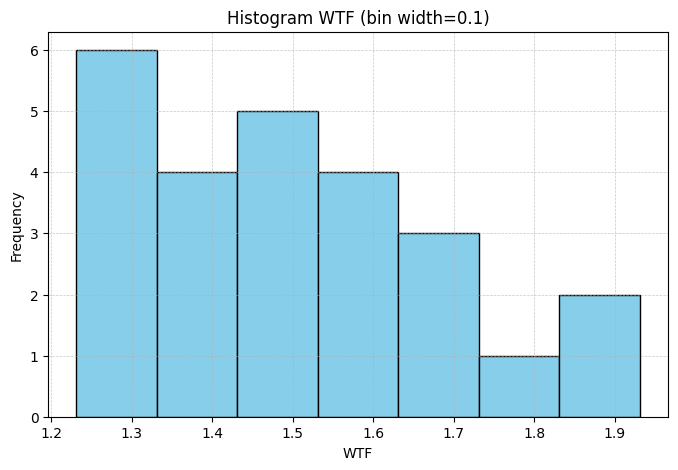


Tabel Histogram WTF:


,Bin Start,Bin End,Frequency
0,1.231341,1.331341,6
1,1.331341,1.431341,4
2,1.431341,1.531341,5
3,1.531341,1.631341,4
4,1.631341,1.731341,3
5,1.731341,1.831341,1
6,1.831341,1.931341,2


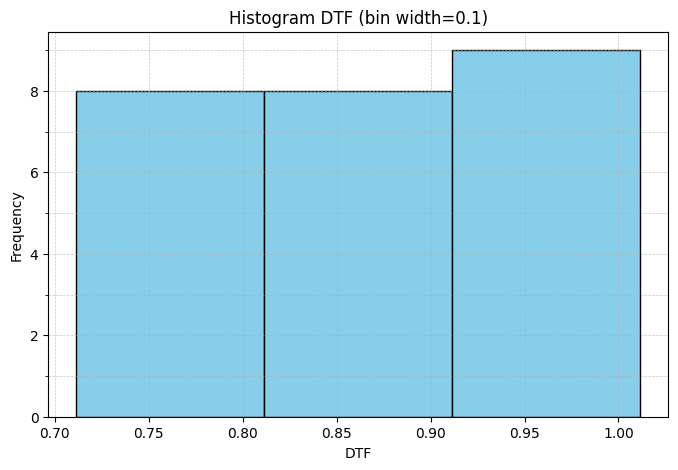


Tabel Histogram DTF:


,Bin Start,Bin End,Frequency
0,0.711441,0.811441,8
1,0.811441,0.911441,8
2,0.911441,1.011441,9


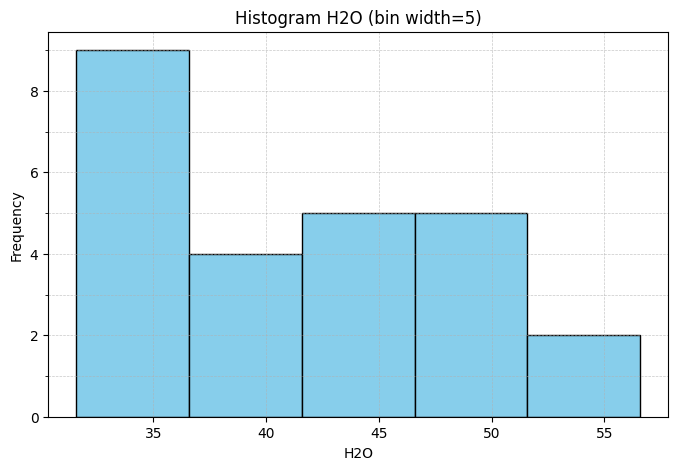


Tabel Histogram H2O:


,Bin Start,Bin End,Frequency
0,31.579,36.579,9
1,36.579,41.579,4
2,41.579,46.579,5
3,46.579,51.579,5
4,51.579,56.579,2


In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator

def plot_histogram_fixed_width(series, bin_width, label):
    data = series.dropna().values
    if len(data) == 0:
        print(f"Tidak ada data untuk {label}.")
        return None

    # Tentukan bins berdasarkan bin_width
    min_val, max_val = data.min(), data.max()
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    # Plot histogram
    plt.figure(figsize=(8,5))
    counts, edges, _ = plt.hist(data, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f"Histogram {label} (bin width={bin_width})")
    plt.xlabel(label)
    plt.ylabel("Frequency")

    # Minor ticks sesuai bin width
    plt.gca().xaxis.set_minor_locator(MultipleLocator(bin_width))
    plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    # Buat tabel histogram
    table = pd.DataFrame({
        "Bin Start": edges[:-1],
        "Bin End": edges[1:],
        "Frequency": counts.astype(int)
    })

    print(f"\nTabel Histogram {label}:")
    display(table)
    return table

# --- Contoh pemanggilan ---
table_wtf = plot_histogram_fixed_width(df_dtf['WTF'], bin_width=0.1, label="WTF")
table_dtf = plot_histogram_fixed_width(df_dtf['DTF'], bin_width=0.1, label="DTF")
table_h2o = plot_histogram_fixed_width(df_dtf['H2O'], bin_width=5, label="H2O")

In [66]:
import pandas as pd

# Input nama Block, GEN_LYR, dan Material
block_name = input("Masukkan nama Block: ")
gen_lyr = input("Masukkan GEN_LYR: ")

# Hitung nilai ringkasan (contoh: mean)
summary = {
    "Block": block_name,
    "GEN_LYR": gen_lyr,
    "Interval_mean": df_dtf['Interval'].dropna().mean(),
    "CoreRec_mean": df_dtf['CoreRec'].dropna().mean(),
    "WetW_mean": df_dtf['WetW'].dropna().mean(),
    "H2O_mean": df_dtf['H2O'].dropna().mean(),
    "DryW_mean": df_dtf['DryW'].dropna().mean(),
    "WTF_mean": df_dtf['WTF'].dropna().mean(),
    "DTF_mean": df_dtf['DTF'].dropna().mean()
}

# Buat nama variabel DataFrame sesuai input
var_name = f"df_{block_name.replace(' ', '_').lower()}_{gen_lyr.lower()}"
globals()[var_name] = pd.DataFrame([summary])

print(f"\nTabel Ringkasan tersimpan sebagai variabel: {var_name}")
display(globals()[var_name])

Masukkan nama Block: Belambus Tengah
Masukkan GEN_LYR: SAP

Tabel Ringkasan tersimpan sebagai variabel: df_belambus_tengah_sap


,Block,GEN_LYR,Interval_mean,CoreRec_mean,WetW_mean,H2O_mean,DryW_mean,WTF_mean,DTF_mean
0,Belambus Tengah,SAP,0.2636,1.0,1.14752,41.69568,0.66752,1.502679,0.867437
